<a href="https://colab.research.google.com/github/jackbowley/MMM/blob/main/MeridianTests/Meridian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/meridian/blob/main/demo/Meridian_Getting_Started.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/meridian/blob/main/demo/Meridian_Getting_Started.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


# **Running test linear national models through meridian**


<a name="install"></a>

## Step 0: Install


1\. Make sure you are using one of the available GPU Colab runtimes which is **required** to run Meridian. You can change your notebook's runtime in `Runtime > Change runtime type` in the menu. All users can use the T4 GPU runtime which is sufficient to run the demo colab, free of charge. Users who have purchased one of Colab's paid plans have access to premium GPUs (such as V100, A100 or L4 Nvidia GPU).


2\. Install the latest version of Meridian, and verify that GPU is available.


In [17]:
import sys, os
IN_COLAB = ('google.colab' in sys.modules) or ('COLAB_RELEASE_TAG' in os.environ)

In [18]:
# Install meridian: from PyPI @ latest release (robust in Colab and local Jupyter)
import sys, subprocess
pkg = "google-meridian[colab,and-cuda]" if IN_COLAB else "google-meridian"
print(f"Installing: {pkg}")
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pkg])
except Exception as e:
    print(f"pip install failed for {pkg}: {e}")

Installing: google-meridian


In [39]:
import arviz as az
import IPython
from meridian import constants
from meridian.analysis import analyzer
from meridian.analysis import formatter
from meridian.analysis import optimizer
from meridian.analysis import summarizer
from meridian.analysis import visualizer
from meridian.data import data_frame_input_data_builder as data_builder
from meridian.data import test_utils
from meridian.model import model
from meridian.model import prior_distribution
from meridian.model import spec
import numpy as np
import pandas as pd
# check if GPU is available
from psutil import virtual_memory
import tensorflow as tf
import tensorflow_probability as tfp

if IN_COLAB:
    from google.colab import drive


ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print(
    'Num GPUs Available: ',
    len(tf.config.experimental.list_physical_devices('GPU')),
)
print(
    'Num CPUs Available: ',
    len(tf.config.experimental.list_physical_devices('CPU')),
)


Your runtime has 16.9 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


### Functions etc.


In [20]:
def import_df_from_drive(filepath):
  """Imports a CSV file from Google Drive into a pandas DataFrame.

  Args:
    filepath: The full path to the CSV file in Google Drive.

  Returns:
    A pandas DataFrame containing the data from the CSV file, or None if an error
    occurs.
  """
  try:
    drive.mount('/content/drive', force_remount=False) # Force remount in case it's already mounted
    df = pd.read_csv(filepath)
    print(f"DataFrame loaded successfully from {filepath}")
    return df
  except FileNotFoundError:
    print(f"Error: The file was not found at {filepath}")
    return None
  except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")
    return None


In [21]:
def import_df_from_local(filename, base_dir='results'):
    """Imports a CSV file from a local 'results' folder into a pandas DataFrame.

    Args:
      filename: The CSV file name inside the results folder (e.g., 'data.csv').
      base_dir: Base directory to look in (defaults to 'results').

    Returns:
      A pandas DataFrame containing the data from the CSV file, or None if an error occurs.
    """
    try:
        if not filename:
            raise ValueError("filename must be provided, e.g., 'data.csv'")
        local_path = os.path.join(base_dir, filename)
        if not os.path.isabs(local_path):
            local_path = os.path.abspath(local_path)
        df = pd.read_csv(local_path)
        print(f"DataFrame loaded successfully from {local_path}")
        return df
    except FileNotFoundError:
        print(f"Error: The file was not found at {local_path}")
        return None
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None


<a name="load-data"></a>

## Step 1: Load the data


### 1\.1 Load Data


In [22]:

# Define the file path to your CSV file in Google Drive.
if IN_COLAB:
    base_dir = '/content/drive/MyDrive/work/MMM'
    filename = 'data_add.csv'
    df_data = import_df_from_drive(os.path.join(base_dir, filename))
    filename= 'var_spec_add.csv'
    df_var_spec = import_df_from_drive(os.path.join(base_dir, filename))
    df_var_spec.head()
else:
    base_dir = 'results'
    filename = 'data_add.csv'
    df_data = import_df_from_local(filename, base_dir=base_dir)
    filename = 'var_spec_add.csv'
    df_var_spec = import_df_from_local(filename, base_dir=base_dir)

DataFrame loaded successfully from c:\Users\User\repos\MMM\MeridianTests\results\data_add.csv
DataFrame loaded successfully from c:\Users\User\repos\MMM\MeridianTests\results\var_spec_add.csv


In [23]:
df = df_data.copy()
df = df.dropna(subset=['svol_xf'])
df = df.rename(columns={'Date': 'time'})
start_date = '2020-06-02'
end_date = '2024-08-27'
df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

2\. Load Data using DataFrameInputDataBuilder


In [24]:
builder = data_builder.DataFrameInputDataBuilder(
    kpi_type='non_revenue',
    default_kpi_column='svol_xf',
    default_revenue_per_kpi_column='price_se_xf',
)

controls = [
    "d_jan","d_feb","d_mar","d_apr","d_may","d_sep","d_oct","d_nov","d_dec",
    "school_easter","school_ht_feb","school_ht_may","school_ht_oct","payday_25",
    "bh_ny","bh_xmas","day_valentine","ww_nat_dlta_maxtemp","ww_nat_dlta_rain",
    "ww_nat_dlta_sun","rsi_nfood_vol_sa","dist_xf",
    "price_se_xf","prom_tft","pos_fsdu","comp_lor_tot","comp_no7_tot"
]

channels = [
    "m_wow_tv","m_wow_olv","m_wow_social","m_amaze_tot","m_celeb_tv","m_celeb_outdoor","m_celeb_display"
]

builder = (
    builder
        .with_kpi(df)
        .with_revenue_per_kpi(df)
        .with_controls(df, control_cols=controls)
)

builder = builder.with_media(
    df,
    media_cols=channels,
    media_spend_cols=channels,
    media_channels=channels,
)

data = builder.build()


<a name="configure-model"></a>

## Step 2: Configure the model


In [25]:
roi_mu = 0.2  # Mu for ROI prior for each media channel.
roi_sigma = 0.9  # Sigma for ROI prior for each media channel.
prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)
model_spec = spec.ModelSpec(prior=prior)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

c:\Users\User\repos\MMM\.venv\Lib\site-packages\meridian\model\model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


2\. Use the `sample_prior()` and `sample_posterior()` methods to obtain samples from the prior and posterior distributions of model parameters. If you are using the T4 GPU runtime this step may take about 10 minutes for the provided data set.


In [ ]:
%%time
mmm.sample_prior(500)
mmm.sample_posterior(
    n_chains=10, n_adapt=2000, n_burnin=500, n_keep=1000, seed=0
)

c:\Users\User\repos\MMM\.venv\Lib\site-packages\meridian\model\prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
c:\Users\User\repos\MMM\.venv\Lib\site-packages\meridian\model\prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
c:\Users\User\repos\MMM\.venv\Lib\site-packages\meridian\model\prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
c:\Users\User\repos\MMM\.venv\Lib\site-packages\meridian\model\prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_

For more information about configuring the parameters and using a customized model specification, such as setting different ROI priors for each media channel, see [Configure the model](https://developers.google.com/meridian/docs/user-guide/configure-model).


<a name="model-diagnostics"></a>

## Step 3: Run model diagnostics


After the model is built, you must assess convergence, debug the model if needed, and then assess the model fit.

1\. Assess convergence. Run the following code to generate r-hat statistics. R-hat close to 1.0 indicate convergence. R-hat < 1.2 indicates approximate convergence and is a reasonable threshold for many problems.


In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

2\. Assess the model's fit by comparing the expected sales against the actual sales.


In [ ]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

For more information and additional model diagnostics checks, see [Modeling diagnostics](https://developers.google.com/meridian/docs/user-guide/model-diagnostics).


<a name="generate-summary"></a>

## Step 4: Generate model results & two-page output


To export the two-page HTML summary output, initialize the `Summarizer` class with the model object. Then pass in the filename, filepath, start date, and end date to `output_model_results_summary` to run the summary for that time duration and save it to the specified file.


In [ ]:
mmm_summarizer = summarizer.Summarizer(mmm)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
filepath = '/content/drive/MyDrive'
start_date = '2021-01-05'
end_date = '2024-08-27'
mmm_summarizer.output_model_results_summary(
    'mock_model_summary_output.html', filepath, start_date, end_date
)

Here is a preview of the two-page output based on the simulated data:


In [ ]:
IPython.display.HTML(filename='/content/drive/MyDrive/mock_model_summary_output.html')

For a customized two-page report, model results summary table, and individual visualizations, see [Model results report](https://developers.google.com/meridian/docs/user-guide/generate-model-results-report) and [plot media visualizations](https://developers.google.com/meridian/docs/user-guide/plot-media-visualizations).


Run the following codes to save the model object:


In [ ]:
file_path = '/content/drive/MyDrive/saved_mmm.pkl'
model.save_mmm(mmm, file_path)

Run the following codes to load the saved model:


In [30]:
## load from local

file_path = "Results\\saved_mmm_additive.pkl"
mmm = model.load_mmm(file_path)

In [ ]:
mmm_summarizer = summarizer.Summarizer(mmm)
analyzer2 = analyzer.Analyzer(mmm)
mediaEffects = visualizer.MediaEffects(mmm)




In [43]:
analyzer2.baseline_summary_metrics()

<xarray.Dataset> Size: 264B
Dimensions:              (metric: 4, distribution: 2)
Coordinates:
  * metric               (metric) <U6 96B 'mean' 'median' 'ci_lo' 'ci_hi'
  * distribution         (distribution) <U9 72B 'prior' 'posterior'
    channel              <U8 32B 'baseline'
Data variables:
    baseline_outcome     (metric, distribution) float32 32B 1.679e+09 ... 1.5...
    pct_of_contribution  (metric, distribution) float32 32B 98.14 ... 97.96

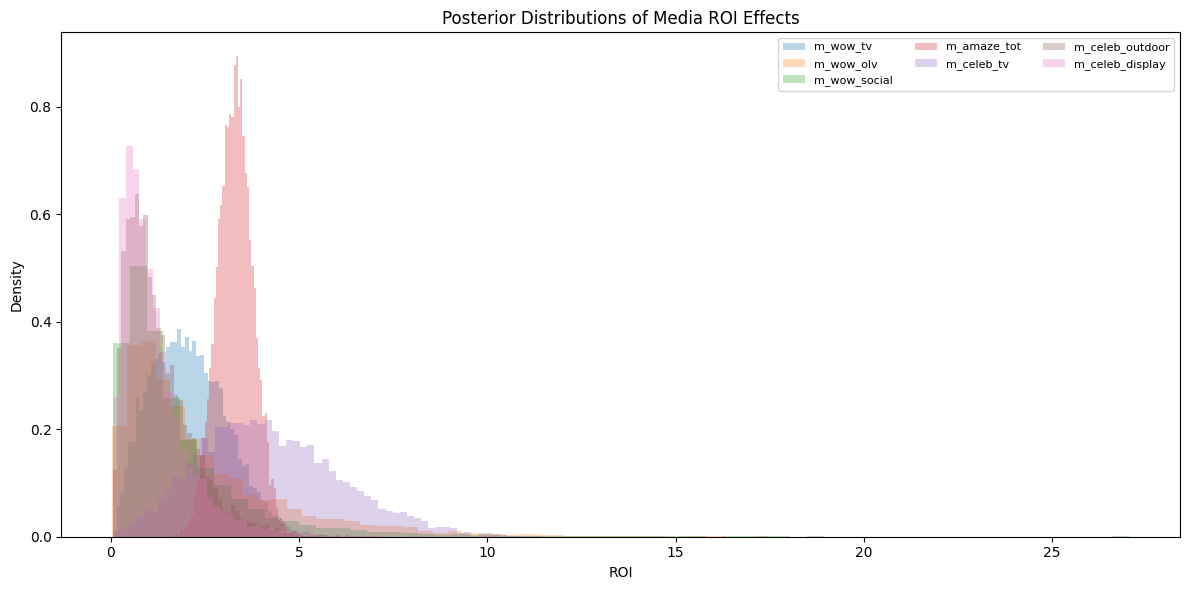

,mean,p5,p50,p95
channel,,,,
m_amaze_tot,3.3008,2.5144,3.3030,4.1013
m_celeb_display,1.1610,0.2325,0.9038,2.9491
m_celeb_outdoor,1.2824,0.2681,1.0470,3.0400
m_celeb_tv,4.2357,1.4524,4.0577,7.6656
m_wow_olv,2.4283,0.3336,1.6874,7.1370
m_wow_social,1.8112,0.2698,1.2142,5.3130
m_wow_tv,2.0766,0.5821,2.0002,3.8419


Source posterior variable(s): roi_m


In [44]:
# Posterior distribution plots for media effects (ROI per channel)
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns  # nicer plots if available
    _HAS_SEABORN = True
except Exception:
    _HAS_SEABORN = False

# 1. Attempt to locate posterior samples for ROI parameters.
roi_var_names = []
roi_samples = None

# Helper: collect candidate arrays (draws x channels OR draws x chains x channels)
def _standardize(arr):
    a = np.array(arr)
    # Flatten chain dimension if present (chains, draws, channels) or (draws, channels)
    if a.ndim == 3:  # (chains, draws, channels)
        a = a.reshape(-1, a.shape[-1])
    elif a.ndim == 2:
        pass
    else:
        return None
    return a

# Try ArviZ inference data first
idata = None
for attr in ["idata", "inference_data", "to_inference_data"]:
    if hasattr(mmm, attr):
        try:
            idata = getattr(mmm, attr)() if callable(getattr(mmm, attr)) else getattr(mmm, attr)
        except Exception:
            pass
    if idata is not None:
        break

if idata is not None and hasattr(idata, "posterior"):
    for var in idata.posterior.data_vars:
        lname = var.lower()
        if re.search(r"roi", lname):
            arr = idata.posterior[var].values  # (chain, draw, …)
            std = _standardize(arr)
            if std is not None:
                roi_var_names.append(var)
                roi_samples = std  # take first matching ROI-like variable
                break

# Fallback: inspect attributes on mmm.samples or mmm
if roi_samples is None:
    for candidate_attr in ["samples", "posterior_samples", "_posterior_samples"]:
        if hasattr(mmm, candidate_attr):
            obj = getattr(mmm, candidate_attr)
            # Look inside dict-like
            if isinstance(obj, dict):
                for k, v in obj.items():
                    if re.search(r"roi", str(k).lower()):
                        std = _standardize(v)
                        if std is not None:
                            roi_var_names.append(k)
                            roi_samples = std
                            break
            if roi_samples is not None:
                break

# If still not found, abort gracefully
if roi_samples is None:
    print("Could not automatically locate ROI posterior samples. Inspect 'mmm' object manually.")
else:
    # Determine channel labels
    try:
        channel_labels = channels  # from earlier cell
    except NameError:
        # Fallback: create generic names
        channel_labels = [f"channel_{i}" for i in range(roi_samples.shape[1])]

    if len(channel_labels) != roi_samples.shape[1]:
        channel_labels = [f"channel_{i}" for i in range(roi_samples.shape[1])]

    # Optional thinning if very large
    max_draws = 20000
    if roi_samples.shape[0] > max_draws:
        step = int(np.ceil(roi_samples.shape[0] / max_draws))
        roi_samples = roi_samples[::step]

    df_roi = pd.DataFrame(roi_samples, columns=channel_labels)
    df_long = df_roi.melt(var_name="channel", value_name="roi")

    # Plot
    plt.figure(figsize=(12, 6))
    if _HAS_SEABORN:
        sns.kdeplot(data=df_long, x="roi", hue="channel", common_norm=False, fill=False)
    else:
        # Manual KDE via histogram overlay
        for ch in channel_labels:
            plt.hist(df_roi[ch], bins=60, density=True, alpha=0.3, label=ch)
    plt.title("Posterior Distributions of Media ROI Effects")
    plt.xlabel("ROI")
    plt.ylabel("Density")
    plt.legend(ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()

    # Summary table (mean, 5%, 50%, 95%)
    summary = df_long.groupby("channel")["roi"].quantile([0.05, 0.5, 0.95]).unstack()
    summary["mean"] = df_long.groupby("channel")["roi"].mean()
    summary = summary[["mean", 0.05, 0.5, 0.95]].rename(columns={0.05: "p5", 0.5: "p50", 0.95: "p95"})
    display(summary.round(4))
    if roi_var_names:
        print("Source posterior variable(s):", ", ".join(roi_var_names))


In [ ]:
# Multi-chart prior vs posterior distributions for ROI per media channel
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re
try:
    import seaborn as sns
    _HAS_SEABORN = True
except Exception:
    _HAS_SEABORN = False

# ---- Helpers ----
def _flatten(arr):
    a = np.array(arr)
    if a.ndim == 3:  # chains, draws, channels
        return a.reshape(-1, a.shape[-1])
    elif a.ndim == 2:  # draws, channels
        return a
    return None

def _find_roi_matrix(idata_section):
    """Return first ROI-like var (name contains 'roi') as 2D matrix draws x channels."""
    if idata_section is None:
        return None, None
    for var in idata_section.data_vars:
        lname = var.lower()
        if 'roi' in lname:
            mat = _flatten(idata_section[var].values)
            if mat is not None and mat.ndim == 2:
                return var, mat
    return None, None

# Attempt to obtain an InferenceData object
data_sources = []
idata = None
for attr in ["idata", "inference_data", "to_inference_data"]:
    if hasattr(mmm, attr):
        try:
            candidate = getattr(mmm, attr)() if callable(getattr(mmm, attr)) else getattr(mmm, attr)
            # ArviZ InferenceData has 'posterior' attr
            if hasattr(candidate, 'posterior'):
                idata = candidate
                break
        except Exception:
            pass

if idata is None:
    print("Could not access InferenceData on model; cannot auto-plot prior vs posterior ROI.")
else:
    # Locate posterior ROI
    post_name, post_mat = _find_roi_matrix(getattr(idata, 'posterior', None))
    # Locate prior ROI (may be absent if not stored)
    prior_name, prior_mat = _find_roi_matrix(getattr(idata, 'prior', None))

    if post_mat is None:
        print("No posterior ROI parameter found (name containing 'roi').")
    elif prior_mat is None:
        print("No prior ROI samples available; plotting posterior only.")
    # Determine channel labels
    try:
        channel_labels = channels
    except NameError:
        channel_labels = [f"channel_{i}" for i in range(post_mat.shape[1])]
    if len(channel_labels) != post_mat.shape[1]:
        channel_labels = [f"channel_{i}" for i in range(post_mat.shape[1])]

    n_ch = post_mat.shape[1]
    ncols = min(4, n_ch)
    nrows = int(np.ceil(n_ch / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharey=False)
    axes = np.atleast_1d(axes).ravel()

    for idx in range(n_ch):
        ax = axes[idx]
        post_series = post_mat[:, idx]
        if prior_mat is not None:
            prior_series = prior_mat[:, idx]
        else:
            prior_series = None

        if _HAS_SEABORN:
            if prior_series is not None:
                sns.kdeplot(prior_series, ax=ax, color='tab:gray', linestyle='--', label='prior')
            sns.kdeplot(post_series, ax=ax, color='tab:blue', label='posterior')
        else:
            # Fallback hist
            if prior_series is not None:
                ax.hist(prior_series, bins=40, density=True, alpha=0.4, color='gray', label='prior')
            ax.hist(post_series, bins=40, density=True, alpha=0.4, color='blue', label='posterior')

        ax.set_title(channel_labels[idx])
        ax.set_xlabel('ROI')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)

    for j in range(n_ch, len(axes)):
        axes[j].axis('off')

    fig.suptitle('Prior vs Posterior ROI Distributions per Media Channel', y=0.995)
    plt.tight_layout(rect=[0,0,1,0.97])
    plt.show()

    # Summary table
    def _summ(stats_arr):
        return {
            'mean': np.mean(stats_arr),
            'p5': np.quantile(stats_arr, 0.05),
            'p50': np.quantile(stats_arr, 0.50),
            'p95': np.quantile(stats_arr, 0.95),
        }

    rows = []
    for i, ch in enumerate(channel_labels):
        row = {'channel': ch}
        if prior_mat is not None:
            row.update({f'prior_{k}': v for k, v in _summ(prior_mat[:, i]).items()})
        row.update({f'posterior_{k}': v for k, v in _summ(post_mat[:, i]).items()})
        rows.append(row)
    summary_df = pd.DataFrame(rows)
    display(summary_df.round(4))

    meta = []
    if prior_mat is not None:
        meta.append(f"prior var: {prior_name}")
    if post_mat is not None:
        meta.append(f"posterior var: {post_name}")
    if meta:
        print(" | ".join(meta))
